In [1]:
import os,sys

import ufl
import dolfin as dl

sys.path.append(os.environ.get('HIPPYLIB_PATH', "../../"))
import hippylib as hp
sys.path.append(os.environ.get('HIPPYFLOW_PATH'))
import hippyflow as hf

import torch

import gempy as gp
import gempy_engine
import gempy_viewer as gpv
from gempy_engine.core.backend_tensor import BackendTensor
from gempy_probability.plot_posterior import default_red, default_blue, PlotPosterior

from helpers import *
from generate_samples import *
from train_nn import *

/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/dolfin/jit/jit.py:121: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  def compile_class(cpp_data, mpi_comm=MPI.comm_world):
/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/dolfin/jit/jit.py:46: RuntimeWarning: mpi4py.MPI.Session size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
  if MPI.size(mpi_comm) == 1:


Setting Backend To: AvailableBackends.numpy


/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup gempy model

In [2]:
# geo_model_test = create_initial_gempy_model_3_layer(refinement=7, save=True)


## Setup the problem

In [3]:
nx = 15; ny = 15
mesh = dl.RectangleMesh(dl.Point(0.0, 0.0), dl.Point(1.0, 1.0), nx, ny)
Vh_STATE = dl.FunctionSpace(mesh, "CG", 2)
Vh_PARAMETER = dl.FunctionSpace(mesh, "CG", 1)
Vh = [Vh_STATE, Vh_PARAMETER, Vh_STATE]

d2v = dl.dof_to_vertex_map(Vh[hp.PARAMETER])
v2d = dl.vertex_to_dof_map(Vh[hp.PARAMETER])


def u_boundary(x, on_boundary):
    return on_boundary and ( x[1] < dl.DOLFIN_EPS or x[1] > 1.0 - dl.DOLFIN_EPS)

u_bdr = dl.Expression("x[1]", degree=1)
u_bdr0 = dl.Constant(0.0)
bc = dl.DirichletBC(Vh[hp.STATE], u_bdr, u_boundary)
bc0 = dl.DirichletBC(Vh[hp.STATE], u_bdr0, u_boundary)

f = dl.Constant(0.0)

def pde_varf(u,m,p):
    return m*ufl.inner(ufl.grad(u), ufl.grad(p))*ufl.dx - f*p*ufl.dx

pde = hp.PDEVariationalProblem(Vh, pde_varf, bc, bc0, is_fwd_linear=True)


## Generate samples of the state.


NOTE I AM USING A SIMPLE MPI RANK PROCESS SO THE ARRAY OPERATION `.get_local()` MAY NEED TO BE MODIFIED IN AN MPI PARALLEL CONTEXT. HOWEVER FOR PROBLEMS THAT ARE THIS SMALL THERE IS NO JUSTIFICATION FOR MPI PARALLELISM FOR THE MESH

In [ ]:
data = generate_input_output_gempy_data(mesh_coordinates=mesh.coordinates(), number_samples=100,filename=None)

/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/gempy/core/data/geo_model.py:164: UserWarning: You are using refinement and passing a regular grid. The resolution of the regular grid will be overwritten
  warnings.warn(


Setting Backend To: AvailableBackends.numpy


Active grids: ['custom']
Setting Backend To: AvailableBackends.PYTORCH


/home/jt925938/anaconda3/envs/gempy_dino/lib/python3.10/site-packages/torch/random.py:166: UserWarning: CUDA reports that you have 4 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of CUDAs. If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using. For example, if you are using CPU only, set device.upper()_VISIBLE_DEVICES= or devices=[]; if you are using device 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(message)


Condition number: 3270.8855697435865.
Condition number: 937.8272903875738.
Condition number: 2436.5127694562807.
Condition number: 3302.2335389751343.
Condition number: 949.318390970095.
Condition number: 1544.511691510481.
Condition number: 1832.502779225806.
Condition number: 2814.176813534337.
Condition number: 1661.4269154415326.
Condition number: 3073.036468041168.
Condition number: 2411.0580625796224.
Condition number: 1627.7737791580153.
Condition number: 3795.6690311011444.
Condition number: 3749.7420342733126.
Condition number: 3737.615611360862.
Condition number: 2890.853976067783.
Condition number: 2198.617452676922.
Condition number: 2489.7020958054213.
Condition number: 1726.7258723242321.
Condition number: 3075.784857827388.
Condition number: 1006.1861044335019.
Condition number: 3771.9519775906892.
Condition number: 2137.800141704474.
Condition number: 1708.003555378283.
Condition number: 2017.2809246578468.
Condition number: 1081.3839946970636.
Condition number: 3608.32

In [5]:
c,m_data, dmdc_data = data["input"],data["Gempy_output"], data["Jacobian_Gempy"]
c.shape, m_data.shape, dmdc_data.shape

((50, 2), (50, 256), (50, 256, 2))

In [6]:
#m_data[8].reshape(11,11)

In [7]:
u_trial = dl.TrialFunction(Vh[hp.STATE])
u_test = dl.TestFunction(Vh[hp.STATE])

M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

I_U = hf.StateSpaceIdentityOperator(M_U)

observable = hf.LinearStateObservable(pde,M_U)

Jm = hf.ObservableJacobian(observable)

m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
m_test = dl.TestFunction(Vh[hp.PARAMETER])

M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

In [8]:
nsamples = c.shape[0]

m = dl.Function(Vh[hp.PARAMETER])

u = dl.Function(Vh[hp.STATE])
uadj = dl.Function(Vh[hp.ADJOINT])

dU = u.vector().get_local().shape[0]

dC = c.shape[1]

# once you have modified the means of c->m(c) comment this
#sol = gp.compute_model(geo_model_test)
#m_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
uhat = dl.Function(Vh[hp.STATE])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
m_hat = dl.Function(Vh[hp.PARAMETER])
u_data = np.zeros((nsamples,dU))
J_data = np.zeros((nsamples, dU, dC))

plotting = False
for sample_index in range(nsamples):
    # Do something here to modify the coefficients
    # sol = gp.compute_model(geo_model_test)
    #m_values = geo_model_test.solutions.octrees_output[0].last_output_center.custom_grid_values
    
    m_values = m_data[sample_index,:]
    m.vector().set_local(m_values[d2v]) #uncomment this
    # m.vector().set_local(m_values[d2v] +0.1*np.random.randn(m_values.shape[0])) #comment this
    if plotting:
        #plt.axis("off")
        dl.plot(m)
        fig = plt.gcf()
        fig.set_size_inches(1, 1)
        plt.show()
    x = [u.vector(),m.vector(),uadj.vector()]
    pde.solveFwd(x[hp.STATE], x)
    
    Jm.observable.setLinearizationPoint(x)
    
    
    # Get the data
    u_data[sample_index,:] = x[hp.STATE].get_local()
    
    for component in range(dC):
        #mhat.vector().set_local(dmdc[:,i])
        m_nodes_hat.vector().set_local(dmdc_data[sample_index,:,component])
        M_M.mult(m_nodes_hat.vector(), m_hat.vector())
        Jm.mult(m_hat.vector(),uhat.vector())
        J_data[sample_index,:,component] = uhat.vector().get_local()
    
u_data.shape, J_data.shape

((50, 961), (50, 961, 2))

## POD

In [9]:
# u_trial = dl.TrialFunction(Vh[hp.STATE])
# u_test = dl.TestFunction(Vh[hp.STATE])

# M_U = dl.assemble(dl.inner(u_trial,u_test)*dl.dx)

POD = hf.PODProjectorFromData(Vh,M_output = M_U)

mean_shifting = True

# Change this later on to be chosen appropriately.
u_rank = len(u_data)
print(u_rank)
d, phi, Mphi, u_shift  = POD.construct_subspace(u_data, u_rank, shifted=mean_shifting, method='hep', verify=True)

50
Using HEP
Preprocessing took 0.000555 seconds
Eigenvalue solve took 0.000856 seconds
Postprocessing took 0.00136 seconds
Basis Orthogonality error: 4.1806954391577753e-07
Basis-Projector Orthogonality error: 4.180695439157775e-07
Mean reconstruction error: 1.511e-11
Max reconstruction error: 4.993e-11


In [10]:
print(d)
r = np.sum(d>=1e-8)

[7.44468967e-05 4.02101165e-05 1.95087467e-06 1.92685969e-06
 8.98955414e-07 2.96440814e-07 1.40237348e-07 8.51733952e-08
 5.70999411e-08 2.29796549e-08 1.54191664e-08 7.14269589e-09
 5.06592031e-09 3.59894401e-09 2.92165588e-09 2.08440141e-09
 1.16259931e-09 6.98626552e-10 5.46775613e-10 4.85582416e-10
 4.07572936e-10 3.13479757e-10 1.96536493e-10 1.33482171e-10
 7.86531342e-11 4.70723559e-11 2.70946730e-11 2.21565008e-11
 1.88877434e-11 8.87917374e-12 6.96083430e-12 6.29955714e-12
 4.64975116e-12 3.97320220e-12 2.01216726e-12 1.74282866e-12
 1.05939010e-12 7.25251020e-13 6.64491495e-13 3.79478302e-13
 2.37906158e-13 1.78352950e-13 1.33491348e-13 5.31353848e-14
 4.98826443e-14 3.30133953e-14 1.36104305e-14 6.52530542e-15
 2.25172569e-15 1.06051257e-21]


In [11]:

Mphi = Mphi[:, :r]
phi = phi[:,:r]
Mphi.shape, phi.shape

((961, 11), (961, 11))

In [12]:
## Compare reconstructions in POD basis

################################################################################
True state


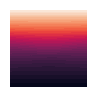

################################################################################
POD projected state


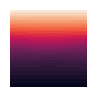

################################################################################
As you can see, this problem is trivial, as only ten modes basically perfectly reconstruct the trivial output function


In [13]:
print(80*'#')
print('True state')
u.vector().set_local(u_data[0])
plt.axis("off")
dl.plot(u)
fig = plt.gcf()
fig.set_size_inches(1, 1)
plt.show()

print(80*'#')
print('POD projected state')
u.vector().set_local(phi@Mphi.T@(u_data[0] - u_shift) + u_shift)
plt.axis("off")
dl.plot(u)
fig = plt.gcf()
fig.set_size_inches(1, 1)
plt.show()

print(80*'#')
print('As you can see, this problem is trivial, as only ten modes basically perfectly reconstruct the trivial output function')

## (Linear) encoders and decoders.

Please consult our papers for a more in-depth discussion. E.g., [section 2.4 in this work](https://arxiv.org/abs/2411.12726)

We can expand a function on an orthonormal basis as

$$ u(x) = \sum_{i=1}^\infty \langle u(x),\phi_i(x)\rangle_\mathcal{U} \phi_i(x)$$

and the truncated representation

$$ u(x) = \sum_{i=1}^r \langle u(x),\phi_i(x)\rangle_\mathcal{U} \phi_i(x)$$

The encoder is the mapping from the data $u(x)$ to its truncated coefficient expansion $\mathcal{E}_r u \in \mathbb{R}^{r}$

$$ \mathcal{E}_r u = \left[\langle u,\phi_i\rangle_\mathcal{U}\right]_{i=1}^r \in \mathbb{R}^{r}$$

The decoder maps this data back to the function space (e.g., the basis expansion operation), given $\alpha \in \mathbb{R}^r$ we have

$$ \mathcal{D}_r \alpha  = \sum_{i=1}^r \alpha_i \phi_i$$

The encoder has the effect of the inner product $\langle \cdot,\cdot\rangle_\mathcal{U}$, e.g., the mass matrix in finite elements, each column of it is $\langle \cdot, \phi\rangle_\mathcal{U}$, so we call it `Mphi` $\in \mathbb{R}^{d_u \times r}$. Likewise we call the decoder `\phi` since its columns are just the basis vectors

### Encoding u data

The mapping to the coefficients of u is $u_r = \mathcal{E}_r u$. In numpy this is `ur_data = Mphi.T@u_data`

### Decoding the u data

We decode with the basis: $\mathcal{D}_r u_r$. In numpy this is `phi@ur_data`

### Encoding and decoding the derivatives.

The derivative of the map is 

$$ Du(c) \in \mathcal{L}(\mathbb{R}^{d_c},\mathcal{U}) $$

that is, the space of linear operators from $\mathbb{R}^{d_c}$ into $\mathcal{U}$. We want to remove the high-dimensionality associated with $\mathcal{U}$

This is done with the encoder operator:

$$\mathcal{E}_r Du(c) \in \mathbb{R}^{r\times d_c}$$

In [14]:
# Encode the u_data

ur = np.einsum('ur,du->dr',Mphi,u_data)

# Encoder the Du_data

dc = 2
Du_data = np.random.randn(nsamples,dU,dc)
Dur_data = np.einsum('ur,duc->drc',Mphi,Du_data)

## Training data

The training data then is inputs (`c_data` \in $\mathbb{R}^{nsamples\times dc}$) and outputs (`ur_data`, `Dur_data`)


## To figure out in the $Du(c)$ calculations

The derivative I believe should have the mass matrix for $\mathcal{M}$ space in it:

$$ Du(c) = D_m(u(m(c)) \frac{dm}{dc} = -\left[\frac{\partial R}{\partial u}\right]^{-1}\frac{\partial R}{\partial m} \frac{dm}{dc}$$

In the other notebook we are evaluating the mapping from $c\mapsto m_\text{node}$, the nodal representation of $m$, but not the function. The mapping to the function requires the mass matrix

The torch gempy code will give you
$$ \frac{dm_\text{node}}{dc}$$

and we need in the end
$$ \frac{dm}{dc} = M_\mathcal{M} \frac{dm_\text{node}}{dc}$$

In [15]:
# Calculating the mass matrix for $\mathcal{M}$


In [16]:
m_trial = dl.TrialFunction(Vh[hp.PARAMETER])
m_test = dl.TestFunction(Vh[hp.PARAMETER])

M_M = dl.assemble(dl.inner(m_trial,m_test)*dl.dx)

## Final form of the pre-reduced Jacobian

$$ Du(c) = -\left[\frac{\partial R}{\partial u}\right]^{-1}\frac{\partial R}{\partial m} M_\mathcal{M}\frac{dm_\text{node}}{dc}$$

Where 

$$ \frac{dm_\text{node}}{dc} \in \mathbb{R}^{d_\text{node}\times dc}$$

is the nodal Jacobian you will get as the output from the gempy torch automatic differntiation

## DOF ORDERING FOR m

You will also need to check the correct degree of freedom mapping for $m$

It will likely be something like the code we had: `m_values[d2v]`

So the output of your torch AD for dm_node/dc will need to have each column reordered using the d2v re-ordering.

When in doubt, plot everything. Do you see that I am constantly plotting to make sure that I am dealing with the right thing? If you get the vertex to dof map wrong you will be able to see it immediately via plotting columns of the Jacobian.

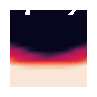

In [17]:
m = dl.Function(Vh[hp.PARAMETER])
m_nodes_hat = dl.Function(Vh[hp.PARAMETER])
m_hat = dl.Function(Vh[hp.PARAMETER])
m.vector().set_local(m_data[0,:][d2v])

plt.axis("off")
dl.plot(m)
fig = plt.gcf()
fig.set_size_inches(1, 1)

################################################################################


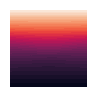

In [18]:
print(80*'#')

u.vector().set_local(u_data[0])
plt.axis("off")
dl.plot(u)
fig = plt.gcf()
fig.set_size_inches(1, 1)
plt.show()

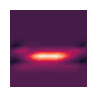

In [19]:
m_nodes_hat.vector().set_local(dmdc_data[0,:,0][d2v])
M_M.mult(m_nodes_hat.vector(), m_hat.vector())
plt.axis("off")
dl.plot(m_hat)
#dl.plot(m_nodes_hat)
fig = plt.gcf()
fig.set_size_inches(1, 1)

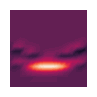

In [20]:
m_nodes_hat.vector().set_local(dmdc_data[0,:,1][d2v])
M_M.mult(m_nodes_hat.vector(), m_hat.vector())
plt.axis("off")
#dl.plot(m_nodes_hat)
dl.plot(m_hat)
fig = plt.gcf()
fig.set_size_inches(1, 1)

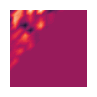

In [21]:
u_hat = dl.Function(Vh[hp.STATE])
u_hat.vector().set_local(J_data[3,:,0][d2v])
plt.axis("off")
dl.plot(u_hat)
fig = plt.gcf()
fig.set_size_inches(1, 1)

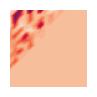

In [22]:
u_hat = dl.Function(Vh[hp.STATE])
u_hat.vector().set_local(J_data[3,:,1][d2v])
plt.axis("off")
dl.plot(u_hat)
fig = plt.gcf()
fig.set_size_inches(1, 1)

In [23]:
Dur = np.einsum('ur,duc->drc',Mphi,J_data)
ur.shape, Dur_data.shape

((50, 11), (50, 11, 2))

In [24]:
train_network(Gempy_Inputs=c, PDE_outputs=ur, Jacobian=Dur, layer_sizes=[c.shape[1],r,r,r,r], num_epochs=100)

torch.Size([11, 11]) torch.Size([2, 2])
Train size: 30,Valid size: 10,  Test size: 10
Epoch [0/100], Train Loss: 0.6354, Val Loss: 0.6235
Epoch [10/100], Train Loss: 0.4796, Val Loss: 0.4704
Epoch [20/100], Train Loss: 0.3561, Val Loss: 0.3487
Epoch [30/100], Train Loss: 0.2563, Val Loss: 0.2507
Epoch [40/100], Train Loss: 0.1798, Val Loss: 0.1757
Epoch [50/100], Train Loss: 0.1227, Val Loss: 0.1202
Epoch [60/100], Train Loss: 0.0830, Val Loss: 0.0813
Epoch [70/100], Train Loss: 0.0548, Val Loss: 0.0537
Epoch [80/100], Train Loss: 0.0350, Val Loss: 0.0343
Epoch [90/100], Train Loss: 0.0216, Val Loss: 0.0212
Epoch [99/100], Train Loss: 0.0135, Val Loss: 0.0133
L2 accuaracy without Jacobian:  tensor(0.7012, device='cuda:0', grad_fn=<RsubBackward1>)


In [25]:
train_network(network_type="full", Gempy_Inputs=c, PDE_outputs=ur, Jacobian=Dur, layer_sizes=[c.shape[1],r,r,r,r], num_epochs=100)

torch.Size([11, 11]) torch.Size([2, 2])
Train size: 30,Valid size: 10,  Test size: 10
Epoch [0/100], Train Loss: 0.3223, Val Loss: 0.3160, L2 Loss: 0.3177, F2 Loss: 0.0047
Epoch [10/100], Train Loss: 0.2434, Val Loss: 0.2381, L2 Loss: 0.2405, F2 Loss: 0.0029
Epoch [20/100], Train Loss: 0.1804, Val Loss: 0.1770, L2 Loss: 0.1788, F2 Loss: 0.0016
Epoch [30/100], Train Loss: 0.1300, Val Loss: 0.1273, L2 Loss: 0.1286, F2 Loss: 0.0014
Epoch [40/100], Train Loss: 0.0909, Val Loss: 0.0889, L2 Loss: 0.0901, F2 Loss: 0.0008
Epoch [50/100], Train Loss: 0.0619, Val Loss: 0.0606, L2 Loss: 0.0616, F2 Loss: 0.0003
Epoch [60/100], Train Loss: 0.0418, Val Loss: 0.0409, L2 Loss: 0.0415, F2 Loss: 0.0003
Epoch [70/100], Train Loss: 0.0275, Val Loss: 0.0269, L2 Loss: 0.0272, F2 Loss: 0.0002
Epoch [80/100], Train Loss: 0.0175, Val Loss: 0.0171, L2 Loss: 0.0173, F2 Loss: 0.0002
Epoch [90/100], Train Loss: 0.0107, Val Loss: 0.0105, L2 Loss: 0.0105, F2 Loss: 0.0002
Epoch [99/100], Train Loss: 0.0067, Val Loss:

In [26]:
train_network(network_type=5, Gempy_Inputs=c, PDE_outputs=ur, Jacobian=Dur, layer_sizes=[c.shape[1],r,r,r,r], num_epochs=100)

torch.Size([11, 11]) torch.Size([2, 2])
Train size: 30,Valid size: 10,  Test size: 10
Epoch [0/100], Train Loss: 0.3220, Val Loss: 0.3155, L2 Loss: 0.3177, F2 Loss: 0.0043
Epoch [10/100], Train Loss: 0.2442, Val Loss: 0.2375, L2 Loss: 0.2405, F2 Loss: 0.0037
Epoch [20/100], Train Loss: 0.1802, Val Loss: 0.1765, L2 Loss: 0.1789, F2 Loss: 0.0013
Epoch [30/100], Train Loss: 0.1301, Val Loss: 0.1275, L2 Loss: 0.1287, F2 Loss: 0.0014
Epoch [40/100], Train Loss: 0.0909, Val Loss: 0.0890, L2 Loss: 0.0901, F2 Loss: 0.0008
Epoch [50/100], Train Loss: 0.0620, Val Loss: 0.0607, L2 Loss: 0.0616, F2 Loss: 0.0004
Epoch [60/100], Train Loss: 0.0418, Val Loss: 0.0409, L2 Loss: 0.0415, F2 Loss: 0.0003
Epoch [70/100], Train Loss: 0.0275, Val Loss: 0.0269, L2 Loss: 0.0272, F2 Loss: 0.0003
Epoch [80/100], Train Loss: 0.0175, Val Loss: 0.0171, L2 Loss: 0.0173, F2 Loss: 0.0002
Epoch [90/100], Train Loss: 0.0108, Val Loss: 0.0105, L2 Loss: 0.0105, F2 Loss: 0.0002
Epoch [99/100], Train Loss: 0.0067, Val Loss: